In [86]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma, uniform
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii

In [5]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)
staff_number = 6
tournament_number = 20

# Faza 1 - przygotowanie

## Wczytanie csv

In [6]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [7]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [8]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [9]:
generated_dates = gen_dates(shop_open_date, today)

In [10]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')

## Ruch - dni

In [11]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(A+B*i+dd)

In [12]:
prompt_dates['volume_base'] = volume_base

In [13]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [14]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,0.4*v_base+szum))

prompt_dates['volume_rental'] = volume_rental

In [15]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7.00,8.00,3.800
1,2021-06-02,Środa,6.01,9.01,1.404
2,2021-06-04,Piątek,11.02,13.02,5.408
3,2021-06-05,Sobota,11.03,11.03,4.412
4,2021-06-07,Poniedziałek,8.04,7.04,3.216


## Tabela procentowa z godzinami

In [16]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [17]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

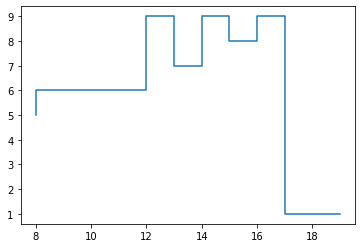

In [18]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [19]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [20]:
sum(hours_prompt['Natężenie'])

1.0000000000000002

## Gry

In [21]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [22]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,Azul Letni Pawilon,planszowa,logiczna,Gra planszowa Azul: Letni Pawilon przenosi nas...,NIE,159.00,NaN,NaN
2,Ryzyk Fizyk,planszowa,towarzyska,Najczęściej nagradzana gra imprezowa! Ile waży...,TAK,104.73,10.0,14
3,5 sekund,inna,familijna,Lubisz adrenalinę? Polubisz 5 sekund! Kultowa ...,NIE,63.41,NaN,NaN
4,Tiletum,planszowa,strategiczna,Czy zostaniesz najważniejszym kupcem renesanso...,NIE,148.00,NaN,NaN


In [23]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [24]:
sum(prompt_games['wagi'])

1.0000000000000002

_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [25]:
id_generator = lambda n: [*range(1, n+1)]


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [26]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'staff_id': [*id_generator(n)],
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [27]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
0,1,MIKOŁAJ,MICHALSKI,697095918,MIKOLAJ.MICHALSKI@allegro.pl,Wrocław,3598.34,False,M,2021-06-01,NaN,2021-06-01 19:39:14
1,2,ADAM,GASIŃSKI,510434349,ADAM.GASINSKI@wp.pl,Wrocław,3602.71,False,M,2021-06-01,NaN,2021-06-01 19:39:14
2,3,PAWEŁ,MIODUSZEWSKI,780699553,PAWEL.MIODUSZEWSKI@tlenofon.pl,Wrocław,3640.68,False,M,2021-06-01,NaN,2021-06-01 19:39:14
3,4,STANISŁAW,SOŚNICKI,792518670,STANISLAW.SOSNICKI@go2.pl,Wrocław,3624.97,False,M,2021-06-01,NaN,2021-06-01 19:39:14
4,5,ŁUKASZ,NITA,453989822,LUKASZ.NITA@outlook.com,Wrocław,NaN,False,M,2021-06-01,2022-07-01,2022-07-01 19:39:14
5,6,MAŁGORZATA,DZWONEK,782024201,MALGORZATA.DZWONEK@polska.pl,Wrocław,3784.92,True,F,2022-07-31,NaN,2022-07-31 19:39:14


## Godziny pracy

In [28]:
hours = range(8,20)
weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']
workers = staff.staff_id
w = []
h = []
for i in range(8,20):
    for j in weekdays:
        w.append(j)
        h.append(i)
wk = []
for i in h:
    if i < 14:
        wk.append((1,2))
    else:
        wk.append((3,4,6))
        
weekday_hour_worker = pd.DataFrame({
    'weekdays': w, 
    'hour': h, 
    'staff': wk
})

In [29]:
weekday_hour_worker

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"
...,...,...,...
67,Wtorek,19,"(3, 4, 6)"
68,Środa,19,"(3, 4, 6)"
69,Czwartek,19,"(3, 4, 6)"
70,Piątek,19,"(3, 4, 6)"


## Związki

In [30]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [31]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_time_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = [*range(1, n+1)]
    df['partner_id'] = [*range(1, n+1)]
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [32]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
7,1,3,M,1,1,2021-06-01 03:03:39
4,2,2,M,2,2,2021-06-09 05:32:24
8,3,3,M,3,1,2021-07-10 17:23:36
0,4,2,M,4,3,2021-07-19 12:44:34
1,5,2,M,5,9,2021-08-27 06:44:12
3,6,1,M,6,1,2021-11-12 21:55:36
5,7,4,M,7,4,2022-01-13 04:26:36
2,8,4,M,8,6,2022-05-10 02:48:22
6,9,4,M,9,3,2022-11-19 07:23:26


## Partnerzy

In [33]:
def partners_df_generator(relationships_df):
    n = relationships_df.shape[0]
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [34]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
7,1,MARTA,F,2021-06-01 03:03:39
4,2,MILENA,F,2021-06-09 05:32:24
8,3,KAROLINA,F,2021-07-10 17:23:36
0,4,JULIA,F,2021-07-19 12:44:34
1,5,JACEK,M,2021-08-27 06:44:12
3,6,GRAŻYNA,F,2021-11-12 21:55:36
5,7,JULIA,F,2022-01-13 04:26:36
2,8,DANUTA,F,2022-05-10 02:48:22
6,9,RENATA,F,2022-11-19 07:23:26


## Klienci - część A

In [35]:
customers = pd.DataFrame({'customer_id': [i for i in range(1,1501)]})

## Koszty utrzymania

In [36]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [37]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'czynsz ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'czynsz')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'energia elektryczna ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'woda ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ogrzewanie ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'pensja')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = [*range(1, df.shape[0]+1)]
    df['invoice_id'] = [*range(1, df.shape[0]+1)]
    df['spend_id'] = [*range(1, df.shape[0]+1)]
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [38]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,energia elektryczna czerwiec,150.43,media,2021-06-05,1,1,2021-06-05 13:34:12
3,2,czynsz czerwiec,3250.00,czynsz,2021-06-05,2,2,2021-06-05 14:20:46
3,3,woda czerwiec,51.68,media,2021-06-05,3,3,2021-06-05 18:43:17
3,4,PENSJA CZERWIEC STANISŁAW SOŚNICKI,3624.97,pensja,2021-06-10,4,4,2021-06-10 08:08:24
5,5,PENSJA CZERWIEC MAŁGORZATA DZWONEK,3784.92,pensja,2021-06-10,5,5,2021-06-10 10:03:28
...,...,...,...,...,...,...,...,...
144,201,PENSJA CZERWIEC MIKOŁAJ MICHALSKI,3598.34,pensja,2023-06-10,201,201,2023-06-10 10:03:11
145,202,PENSJA CZERWIEC ADAM GASIŃSKI,3602.71,pensja,2023-06-10,202,202,2023-06-10 11:04:39
147,203,PENSJA CZERWIEC STANISŁAW SOŚNICKI,3624.97,pensja,2023-06-10,203,203,2023-06-10 13:05:44
149,204,PENSJA CZERWIEC MAŁGORZATA DZWONEK,3784.92,pensja,2023-06-10,204,204,2023-06-10 15:45:47


## Typy wydatków

In [39]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df['expenses_type_id'] = [*range(1, df.shape[0]+1)]
    df.sort_values(by=['updated_at'], inplace=True)
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [40]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,czynsz,2023-06-05 17:30:56
612,2,media,2023-06-05 18:41:39
146,3,pensja,2023-06-10 16:37:29


## Tytuły wydatków

In [41]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df['title_id'] = [*range(1, df.shape[0]+1)]
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [42]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA LIPIEC ŁUKASZ NITA,3,2021-07-10 18:07:11
1,2,PENSJA SIERPIEŃ ŁUKASZ NITA,3,2021-08-10 09:05:07
2,3,PENSJA WRZESIEŃ ŁUKASZ NITA,3,2021-09-10 15:28:30
3,4,PENSJA PAŹDZIERNIK ŁUKASZ NITA,3,2021-10-11 10:29:25
4,5,PENSJA LISTOPAD ŁUKASZ NITA,3,2021-11-10 09:08:39


## Wydatki i tytuły jeszcze raz

In [43]:
maintenance_expenses = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses = maintenance_expenses.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [44]:
maintenance_expenses.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,108,media,150.43,1,1,2021-06-05 13:34:12
1,2,107,czynsz,3250.00,2,2,2021-06-05 14:20:46
2,3,106,media,51.68,3,3,2021-06-05 18:43:17
3,4,111,pensja,3624.97,4,4,2021-06-10 08:08:24
4,5,112,pensja,3784.92,5,5,2021-06-10 10:03:28


## Turnieje

In [140]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == 'Piątek') & (weekday_hour_worker['hour'] >= 15)]['staff'].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2**x
        x -= 1
    return suma

def matches_generator(tournament_df):
    players = pd.merge(tournament_df[['game']], prompt_games, left_on=['game'], right_on=['Nazwa'], how='left')[['game', 'Liczba uczestników']]
    players['Liczba uczestników'] = players['Liczba uczestników'].astype('int')
    players['possible'] = uniform.rvs(loc=5, scale=8, size=players.shape[0])
    players['C'] = (players['Liczba uczestników'] * players['possible']).apply(lambda x: int(round(x, 0)))
    players['B'] = players['C'].apply(lambda x: int(np.log2(x)))
    tournament_df['matches'] = players['B'].apply(lambda x: count_matches(x))

In [143]:
def tournament_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    tournament = game_tournament_generator()
    tournament = tournament.sample(dates.shape[0], replace=False, ignore_index=True) #nie może być ten sam wiersz
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'start_time': dates + datetime.timedelta(hours=15),
        'fee': np.full((1, dates.shape[0]), 50)[0],
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'staff_id': [tournament_staff_generator() for i in range(dates.shape[0])],
        'expenses': map(lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=dates.shape[0])),
        'updated_at': dates + datetime.timedelta(hours=15)
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['tournament_id'] = [*range(1, dates.shape[0]+1)]
    matches_generator(df)
    df = df.reindex(['tournament_id', 'name', 'game', 'start_time', 'matches', 'fee', 'sign_up_deadline', 'staff_id', 'expenses', 'updated_at'], axis=1)
    return df

In [145]:
tournament = tournament_df_generator()
tournament

,tournament_id,name,game,start_time,matches,fee,sign_up_deadline,staff_id,expenses,updated_at
0,1,Cytadela Strategii,Catan: Osadnicy z Catanu,2021-06-04 15:00:00,31,50,2021-06-01 20:00:00,4,265.11,2021-06-04 15:00:00
1,2,Krucjata Karcianych Mistrzów,Munchkin,2021-07-16 15:00:00,63,50,2021-07-13 20:00:00,4,211.49,2021-07-16 15:00:00
2,3,Rewolucja Planszowych Geniuszy,Mastermind,2021-08-27 15:00:00,31,50,2021-08-24 20:00:00,4,226.41,2021-08-27 15:00:00
3,4,Wrocławski Konwent Planszówkowy,Catan: Osadnicy z Catanu,2021-10-08 15:00:00,31,50,2021-10-05 20:00:00,4,290.04,2021-10-08 15:00:00
4,5,Familijna Rewolucja,Wsiąść do Pociągu: Europa,2021-11-19 15:00:00,63,50,2021-11-16 20:00:00,4,237.59,2021-11-19 15:00:00
5,6,Potyczka Prawdziwych Kolosów,Ryzyk Fizyk,2021-12-31 15:00:00,127,50,2021-12-28 20:00:00,3,214.15,2021-12-31 15:00:00
6,7,Wrocławski Konwent Planszówkowy,7 Cudów Świata,2022-02-11 15:00:00,127,50,2022-02-08 20:00:00,6,216.56,2022-02-11 15:00:00
7,8,Wrocławski Konwent Planszówkowy,Scythe,2022-03-25 15:00:00,63,50,2022-03-22 20:00:00,4,247.44,2022-03-25 15:00:00
8,9,Krucjata Karcianych Mistrzów,Tajniacy,2022-05-06 15:00:00,63,50,2022-05-03 20:00:00,6,219.41,2022-05-06 15:00:00
9,10,Krucjata Karcianych Mistrzów,UNO,2022-06-17 15:00:00,127,50,2022-06-14 20:00:00,4,219.20,2022-06-17 15:00:00


## Udziały

## Magazyn

## Ceny gier

## Sprzedaże

## Rentale

## Gry

## Katrgorie gier i typy gier

## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele